# Stage 1: Data preprocessing

In this tutorial, we will show how to prepare the necessary data for GLUE model training, using the SNARE-seq data ([Chen, et al. 2019](https://doi.org/10.1038/s41587-019-0290-0)) as an example. The SNARE-seq data consists of paired scRNA-seq and scATAC-seq profiles, but we will treat them as unpaired and try to align these two omics layers using GLUE.

In [2]:
import os

# bedtoolsのパスを追加
bedtools_path = '/opt/homebrew/bin'  # bedtoolsのインストールされているパス
os.environ['PATH'] += os.pathsep + bedtools_path

# PATHを確認（オプション）
print(os.environ['PATH'])


/Users/koba/.pyenv/versions/3.11.3/bin:/Users/koba/anaconda3/condabin:/Users/koba/.pyenv/shims/python3.11:/Users/koba/.pyenv/shims:/Users/koba/.pyenv/bin:/Library/Frameworks/Python.framework/Versions/3.10/bin:/Library/Frameworks/Python.framework/Versions/3.11/bin:/opt/homebrew/bin:/opt/homebrew/sbin:/usr/local/bin:/System/Cryptexes/App/usr/bin:/usr/bin:/bin:/usr/sbin:/sbin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/local/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/appleinternal/bin:/opt/X11/bin:/Library/Apple/usr/bin:/Library/TeX/texbin:/opt/homebrew/bin


In [3]:
import anndata as ad
import networkx as nx
import scanpy as sc
import scglue
from matplotlib import rcParams

# import sys
# print(sys.path)

In [4]:
scglue.plot.set_publication_params()
rcParams["figure.figsize"] = (4, 4)

## Read data

First, we need to prepare the scRNA-seq and scATAC-seq data into `AnnData` objects. `AnnData` is the standard data class we use in `scglue`. See their [documentation](https://anndata.readthedocs.io/en/latest/index.html) for more details if you are unfamiliar, including how to construct `AnnData` objects from scratch, and how to read data in other formats (csv, mtx, loom, etc.) into `AnnData` objects.

Here we just load existing `h5ad` files, which is the native file format for `AnnData`. The `h5ad` files used in this tutorial can be downloaded from here:

* [http://download.gao-lab.org/GLUE/tutorial/Chen-2019-RNA.h5ad](http://download.gao-lab.org/GLUE/tutorial/Chen-2019-RNA.h5ad)
* [http://download.gao-lab.org/GLUE/tutorial/Chen-2019-ATAC.h5ad](http://download.gao-lab.org/GLUE/tutorial/Chen-2019-ATAC.h5ad)

In [5]:
rna = ad.read_h5ad("Chen-2019-RNA.h5ad")
rna

AnnData object with n_obs × n_vars = 9190 × 28930
    obs: 'domain', 'cell_type'

In [6]:
atac = ad.read_h5ad("Chen-2019-ATAC.h5ad")
atac

AnnData object with n_obs × n_vars = 9190 × 241757
    obs: 'domain', 'cell_type'

## Preprocess scRNA-seq data

> (Estimated time: ~2 min)

To begin with, the scRNA-seq expression matrix is supposed to contain raw UMI counts:

In [7]:
rna.X, rna.X.data

(<9190x28930 sparse matrix of type '<class 'numpy.float32'>'
 	with 8633857 stored elements in Compressed Sparse Row format>,
 array([1., 1., 1., ..., 1., 1., 1.], dtype=float32))

Before any preprocessing, we back up the raw UMI counts in a layer called "counts". It will be used later during model training.

In [8]:
rna.layers["counts"] = rna.X.copy()



Then follow a minimal `scanpy` pipeline for data preprocessing (see their [tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) if you are unfamiliar).

First up we use the "seurat_v3" method to select 2,000 highly variable genes.

In [9]:
sc.pp.highly_variable_genes(rna, n_top_genes=2000, flavor="seurat_v3")

Then normalize, scale the data, and perform dimension reduction via PCA. By default, 100 principal components are used.

The PCA embedding will be used in [stage 2](training.ipynb#Configure-data) as the first encoder transformation to reduce model size.

In [10]:
sc.pp.normalize_total(rna)
sc.pp.log1p(rna)
sc.pp.scale(rna)
sc.tl.pca(rna, n_comps=100, svd_solver="auto")

Optionally, we can visualize the RNA domain with UMAP.

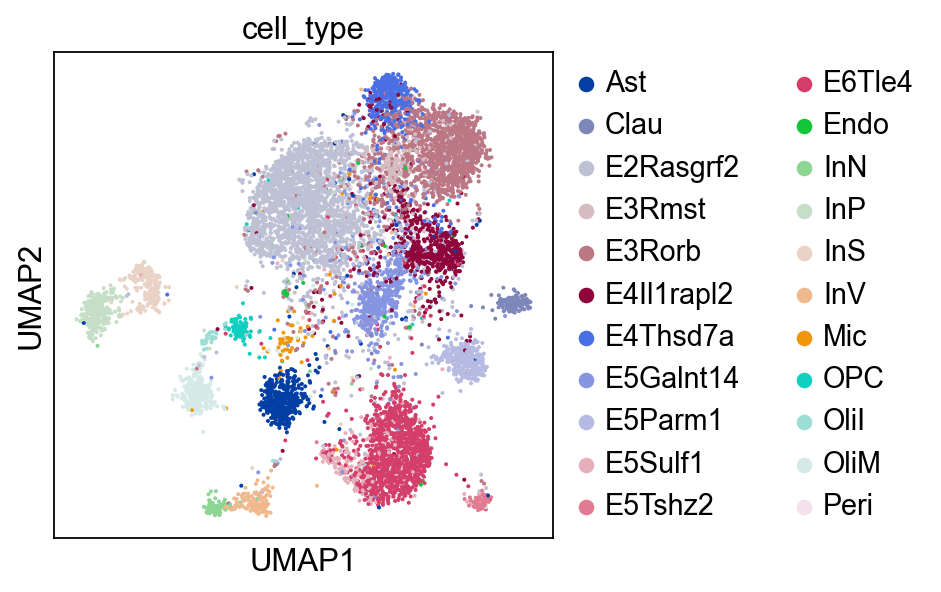

In [11]:
sc.pp.neighbors(rna, metric="cosine")
sc.tl.umap(rna)
sc.pl.umap(rna, color="cell_type")

## Preprocess scATAC-seq data

> (Estimated time: ~2 min)

Similar to scRNA-seq, the scATAC-seq accessibility matrix is also supposed to contain raw counts.

In [12]:
atac.X, atac.X.data

(<9190x241757 sparse matrix of type '<class 'numpy.float32'>'
 	with 22575391 stored elements in Compressed Sparse Row format>,
 array([1., 1., 1., ..., 1., 1., 1.], dtype=float32))

For scATAC-seq, we apply the latent semantic indexing (LSI) for dimension reduction, using the function [scglue.data.lsi](api/scglue.data.lsi.rst). This is just a Python reimplementation of the LSI function in [Signac](https://satijalab.org/signac/). We also set the dimensionality to 100. The other keyword argument `n_iter=15` is passed to [sklearn.utils.extmath.randomized_svd](https://scikit-learn.org/stable/modules/generated/sklearn.utils.extmath.randomized_svd.html). Setting it to larger values increases the precision of randomized SVD.

The LSI embedding will be used in [stage 2](training.ipynb#Configure-data) as the first encoder transformation to reduce model size.

In [13]:
scglue.data.lsi(atac, n_components=100, n_iter=15)

Optionally, we may also visualize the ATAC domain with UMAP.

In [14]:
sc.pp.neighbors(atac, use_rep="X_lsi", metric="cosine")
sc.tl.umap(atac)

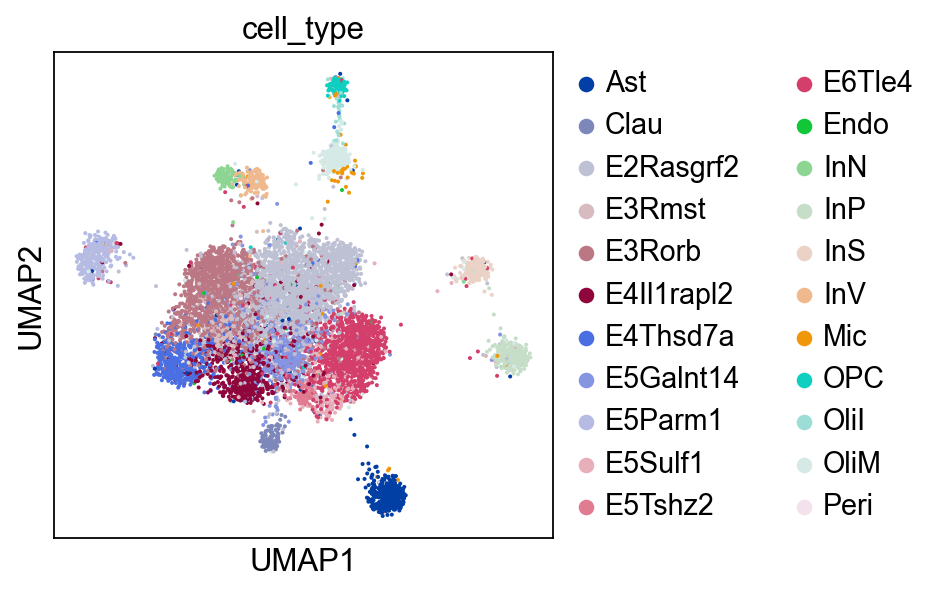

In [15]:
sc.pl.umap(atac, color="cell_type")

## Construct prior regulatory graph

> Estimated time: ~2 min

Next, we need to construct the guidance graph, which will be utilized by GLUE to orient the multi-omics alignment. The graph should contain omics features as nodes (e.g., genes for scRNA-seq, and peaks for scATAC-seq), and prior regulatory interactions as edges.

GLUE accepts guidance graph in the form of [networkx](https://networkx.org/) graph objects (see this [introduction](https://networkx.org/documentation/stable/reference/introduction.html) if you are unfamilar). So, in principle, you can manually construct the guidance graph tailored to your need, as long as the graph complies to the following standards:

* The [graph nodes](https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.nodes.html) should cover all [omics features](https://anndata.readthedocs.io/en/latest/anndata.AnnData.var_names.html) in the datasets to be integrated.
* The [graph edges](https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.edges.html) should contain "weight" and "sign" as edge attributes. Weights should have range (0, 1], and signs should take values of either 1 or -1.
* The graph should contain a self-loop for each node, with weight = 1, and sign = 1.
* It is recommended to use undirected graphs ([Graph](https://networkx.org/documentation/stable/reference/classes/graph.html), [MultiGraph](https://networkx.org/documentation/stable/reference/classes/multigraph.html)), or symmetric directed graphs ([DiGraph](https://networkx.org/documentation/stable/reference/classes/digraph.html), [MultiDiGraph](https://networkx.org/documentation/stable/reference/classes/multidigraph.html)).

Below, we show how to construct a guidance graph for scRNA-seq and scATAC-seq integration, using builtin functions in `scglue`.

### Obtain genomic coordinates

The most commonly used prior information linking ATAC peaks with genes is genomic proximity. To do so, we need the genomic coordinates for peaks and genes, and store them as feature meta data in the [var](https://anndata.readthedocs.io/en/latest/anndata.AnnData.var.html#anndata.AnnData.var) slot.

For typical scRNA-seq datasets, only the gene names/IDs are stored, but not their coordinates, as is the case here:

In [16]:
rna.var.head()

,highly_variable,highly_variable_rank,means,variances,variances_norm,mean,std
genes,,,,,,,
0610005C13Rik,False,NaN,0.001415,0.001413,0.958918,0.000832,0.024802
0610009B22Rik,True,1528.0,0.017301,0.022228,1.126013,0.010283,0.091634
0610009E02Rik,False,NaN,0.014799,0.017193,1.023411,0.008182,0.076223
0610009L18Rik,False,NaN,0.016540,0.020403,1.082735,0.009849,0.088678
0610010F05Rik,False,NaN,0.157563,0.197176,1.004244,0.086493,0.245927


So, we provide a utility function [scglue.data.get_gene_annotation](api/scglue.data.get_gene_annotation.rst) to supplement the coordinate information from GTF files. The following usage assumes that the `rna.var_names` correspond to "gene_name" attribute in the GTF file. For other cases, please check the [function documentation](api/scglue.data.get_gene_annotation.rst).

The GTF file used here can be downloaded from [GENCODE](ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M25/gencode.vM25.chr_patch_hapl_scaff.annotation.gtf.gz).

In [17]:
scglue.data.get_gene_annotation(
    rna, gtf="gencode.vM25.chr_patch_hapl_scaff.annotation.gtf.gz",
    gtf_by="gene_name"
)
rna.var.loc[:, ["chrom", "chromStart", "chromEnd"]].head()

,chrom,chromStart,chromEnd
genes,,,
0610005C13Rik,chr7,45567793,45575327
0610009B22Rik,chr11,51685385,51688874
0610009E02Rik,chr2,26445695,26459390
0610009L18Rik,chr11,120348677,120351190
0610010F05Rik,chr11,23564960,23633639


Note that the coordinates have column names "chrom", "chromStart" and "chromEnd", corresponding to the first three columns of the [BED format](https://genome.ucsc.edu/FAQ/FAQformat.html#format1). These exact column names are required. Alternative names like "chr", "start", "end" are **NOT** recognized.

For the scATAC-seq data, the coordinates are already in `var_names`. We just need to extract them.

In [18]:
atac.var_names[:5]

Index(['chr1:3005833-3005982', 'chr1:3094772-3095489', 'chr1:3119556-3120739',
       'chr1:3121334-3121696', 'chr1:3134637-3135032'],
      dtype='object', name='peaks')

In [19]:
split = atac.var_names.str.split(r"[:-]")
atac.var["chrom"] = split.map(lambda x: x[0])
atac.var["chromStart"] = split.map(lambda x: x[1]).astype(int)
atac.var["chromEnd"] = split.map(lambda x: x[2]).astype(int)
atac.var.head()

,chrom,chromStart,chromEnd
peaks,,,
chr1:3005833-3005982,chr1,3005833,3005982
chr1:3094772-3095489,chr1,3094772,3095489
chr1:3119556-3120739,chr1,3119556,3120739
chr1:3121334-3121696,chr1,3121334,3121696
chr1:3134637-3135032,chr1,3134637,3135032


### Graph construction

Now that we have the genomic coordinates for all omics features, we can use the [scglue.genomics.rna_anchored_guidance_graph](api/scglue.genomics.rna_anchored_guidance_graph.rst) function to construct the guidance graph.

By default, an ATAC peak is connected to a gene if they overlap in either the gene body or promoter region. See the [function documentation](api/scglue.genomics.rna_anchored_guidance_graph.rst) for adjustable settings.

In [20]:
guidance = scglue.genomics.rna_anchored_guidance_graph(rna, atac)
guidance

window_graph:   0%|          | 0/28930 [00:00<?, ?it/s]

We can verify that the obtained guidance graph complies to all of the previous standards using the [scglue.graph.check_graph](api/scglue.graph.check_graph.rst) function.

In [21]:
scglue.graph.check_graph(guidance, [rna, atac])

[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!


In the meantime, note that highly variable features have been propagated to the ATAC domain, by marking peaks reachable from the highly variable genes in the guidance graph:

In [22]:
atac.var.head()

,chrom,chromStart,chromEnd,highly_variable
peaks,,,,
chr1:3005833-3005982,chr1,3005833,3005982,False
chr1:3094772-3095489,chr1,3094772,3095489,False
chr1:3119556-3120739,chr1,3119556,3120739,False
chr1:3121334-3121696,chr1,3121334,3121696,False
chr1:3134637-3135032,chr1,3134637,3135032,False


If the [rna_anchored_guidance_graph](api/scglue.genomics.rna_anchored_guidance_graph.rst) function doesn't meet the need (e.g., if you want to incorporate experimental regulatory evidences), you may need to construct the guidance graph manually. We also provide some lower-level utilities like to help (e.g., [scglue.genomics.window_graph](api/scglue.genomics.window_graph.rst), [scglue.graph.compose_multigraph](api/scglue.graph.compose_multigraph.rst), [scglue.graph.reachable_vertices](api/scglue.graph.reachable_vertices.rst)). Please refer to our [case study](https://github.com/gao-lab/GLUE/tree/master/experiments/RegInf/s01_preprocessing.ipynb) for an example, where we combined genomic proximity with pcHi-C and eQTL evidences to construct a hybrid prior regulatory graph.

## Save preprocessed data files

Finally, we save the preprocessed data, for use in [stage 2](training.ipynb).

In [23]:
rna.write("rna-pp.h5ad", compression="gzip")
atac.write("atac-pp.h5ad", compression="gzip")
nx.write_graphml(guidance, "guidance.graphml.gz")